# data process

In [105]:
import pandas as pd
import os
import shutil
import random

In [76]:
train_file = 'trainv2.tsv'
train_samples = pd.read_csv(train_file, sep='\t', header=None)
train_samples = train_samples.values.tolist()

test_file = 'testv2.tsv'
test_samples = pd.read_csv(test_file, sep='\t', header=None)
test_samples = test_samples.values.tolist()
all_samples = train_samples + test_samples
print(len(all_samples))
all_unique_samples = list(set([tuple(all_sample) for all_sample in all_samples]))
random.shuffle(all_unique_samples)
# count = 0
# for s in list(set([tuple(all_sample) for all_sample in all_samples])):
#     img_name = s[0] + '.json'

#     label = s[2]
#     if os.path.exists('orig_json/'+ img_name):
#         shutil.copy('orig_json/' + img_name, 'json/' + str(label) + '/' + img_name)
#         count += 1
#     else:
#         print(img_name)
# print(count)

3458


In [153]:
dirs = os.listdir('receipt_data/data_v2')
label_list = open('receipt_data/labels_v2.txt').read().split('\n')
label_map = {str(i): label for i, label in enumerate(label_list)}

train_samples, dev_samples = [], []
for label in dirs:
    num = len(os.listdir(os.path.join('receipt_data/data_v2', label)))
    dev_num = num // 10
    count = 0
    files = os.listdir(os.path.join('receipt_data/data_v2', label))
    random.shuffle(files)
    for file in files:
        if count < dev_num:
            count += 1
            dev_samples.append(['data_v2/' + label + '/'+ file, 'json_v2/' + label + '/'+ file.replace('jpg', 'json'), label_map[label]])
        else:
            train_samples.append(['data_v2/' + label + '/'+ file, 'json_v2/' + label + '/'+ file.replace('jpg', 'json'), label_map[label]])

    
df_train = pd.DataFrame.from_dict(train_samples)
df_train.to_csv('receipt_data/train_v2.csv', index=False, header=None, sep=',')   

df_train = pd.DataFrame.from_dict(dev_samples)
df_train.to_csv('receipt_data/dev_v2.csv', index=False,  header=None, sep=',')  

In [13]:
import shutil
from tqdm import tqdm 
import pandas as pd

with open('outputs/out.txt') as f:
    data = f.read().split()

test_samples = []
for data_one in tqdm(data):
    label,img_file = data_one.split('/')
    #print(img_file)
    #shutil.copy('origin_data/orig_data/' + img_file, 'receipt_data/test_data/'+ img_file)
    json_file = img_file.replace('jpg', 'json')
    #shutil.copy('origin_data/orig_json/' + json_file, 'receipt_data/test_json/' + json_file)
    if label in ['入院记录', '出院记录']:
        test_samples.append(['test_data/'+ img_file, 'test_json/' + json_file, '住院记录'])
    elif label == '费用清单':
        test_samples.append(['test_data/'+ img_file, 'test_json/'+ json_file, '费用明细单'])  
    else:
        test_samples.append(['test_data/' + img_file, 'test_json/'+ json_file, label])
        
df_train = pd.DataFrame.from_dict(test_samples)
df_train.to_csv('receipt_data/test_v2.csv', index=False,  header=None, sep=',')         

100%|██████████| 40417/40417 [00:00<00:00, 384661.71it/s]


In [36]:
total = 0
prior = []
dirs = os.listdir('receipt_data/data_v2')
for label in dirs:
    num = len(os.listdir(os.path.join('receipt_data/data_v2', label)))
    #print(label, '>>>', num - num // 10)
    print(label, '>>>', num)
    prior.append(round((num - num // 10) / 4076, 2))
    total += (num - num // 10)
    
print(total)
print((prior))

0 >>> 34
5 >>> 649
10 >>> 923
3 >>> 210
8 >>> 913
13 >>> 728
4 >>> 80
2 >>> 277
7 >>> 201
6 >>> 107
1 >>> 368
11 >>> 926
9 >>> 137
12 >>> 44
5044
[0.01, 0.14, 0.2, 0.05, 0.2, 0.16, 0.02, 0.06, 0.04, 0.02, 0.08, 0.2, 0.03, 0.01]


# 命令行

In [ ]:
# 单GPU
CUDA_VISIBLE_DEVICES=7 python train.py --data_dir receipt_data --model_type layoutlm --img_model_type resnet34\
 --model_name_or_path check_points/layout_large_uncased_pretrained_cn --do_lower_case --max_seq_length 512 \
 --do_train --num_train_epochs 30 --logging_steps 500 --save_steps 500 --output_dir check_points/recip_cls_v1 \
 --labels receipt_data/labels.txt --per_gpu_train_batch_size 4 --overwrite_output_dir

# 多GPU (训练)
CUDA_VISIBLE_DEVICES='6,7' python train.py --data_dir receipt_data --model_type layoutlm --img_model_type resnet50\
 --model_name_or_path check_points/layout_base --do_lower_case --max_seq_length 512\
 --do_train --num_train_epochs 12 --logging_steps 700 --save_steps 700 --output_dir check_points/recip_cls_v4_smooth_base\
 --labels receipt_data/labels_v2.txt --per_gpu_train_batch_size 4 --overwrite_output_dir --evaluate_during_training

(验证)  base(v2): 1200/2700; base(v3): 5400; large: 1500
CUDA_VISIBLE_DEVICES='6,7' python test.py --data_dir receipt_data --model_type layoutlm --img_model_type resnet50\
 --model_name_or_path check_points/recip_cls_v3_base/checkpoint-6600 --do_lower_case --max_seq_length 512\
 --do_predict --num_train_epochs 12 --logging_steps 300 --save_steps 300 --output_dir check_points/recip_cls_v3_base\
 --labels receipt_data/labels_v2.txt --per_gpu_eval_batch_size 4 --overwrite_output_dir 

(测试)  base(v2): 1200/2700; base(v3): 5400; base(v4): 7000; base(v4_smooth): 9100
CUDA_VISIBLE_DEVICES='6,7' python test.py --data_dir receipt_data --model_type layoutlm --img_model_type resnet50\
 --model_name_or_path check_points/recip_cls_v4_base/checkpoint-7000 --do_lower_case --max_seq_length 512\
 --do_predict --num_train_epochs 12 --logging_steps 300 --save_steps 300 --output_dir check_points/recip_cls_v4_base\
 --labels receipt_data/labels_v2.txt --per_gpu_eval_batch_size 4 --overwrite_output_dir 

训练集：{'住院病案首页': 31, '住院记录': 333, '门诊病历': 253, '处方': 195, '诊断证明': 73, '费用明细单': 613, '增值税发票': 97, '检查报告': 183, '费用结算单': 868, '检验单': 124,'其它材料': 848, '医疗发票': 848, '手术记录': 40, '小票': 666} ,共5172，前一版4076

验证集: {'住院病案首页': 3, '住院记录': 37, '门诊病历': 24, '处方': 17, '诊断证明': 8, '费用明细单': 34, '增值税发票': 10, '检查报告': 18, '费用结算单': 47, '检验单': 13, '其它材料': 71, '医疗发票': 77, '手术记录': 4, '小票': 62}, 共425，前一版446

实验结果:
Test: acc 0.96706, macro_f1 0.9729438346891562, micro_f1 0.9670588235294117

In [170]:
total = 0
prior = []
train_files = pd.read_csv('receipt_data/train_v2.csv', header=None).values.tolist()
len(train_files)
label_list = open('receipt_data/labels_v2.txt').read().split('\n')
num_list = []
for label in label_list:
    num = 0
    for train_file in train_files:
        if train_file[2] == label:
            num += 1
    num_list.append(num)
    
for num in num_list:
    prior.append(round(num / sum(num_list), 2))
    
print((num_list))
print(prior)

[105, 384, 344, 206, 147, 859, 106, 198, 937, 128, 1155, 964, 43, 716]
[0.02, 0.06, 0.05, 0.03, 0.02, 0.14, 0.02, 0.03, 0.15, 0.02, 0.18, 0.15, 0.01, 0.11]


In [123]:
label_list = open('receipt_data/labels_v2.txt').read().split('\n')
label_map = {label: str(i) for i, label in enumerate(label_list)}

anno_files = open('outputs/log.txt').read().split('\n')
anno_files_ = [anno_file.split('/')[1].replace('jpg', 'json') for anno_file in anno_files]

# for root, dirs, files in os.walk('receipt_data/json_v2/'):
#     for file in files:
#         if file in anno_files_:
#             print(file)
#             os.remove(os.path.join(root, file))

for file in anno_files:
    
    label, img_file = label_map[file.split('/')[0]], file.split('/')[1]
    #print(img_file, label)
    json_file = img_file.replace('jpg', 'json')
    #break
    shutil.copy('origin_data/orig_data/' + img_file, 'receipt_data/data_v2/' + label + '/ ' + img_file) 
    shutil.copy('origin_data/orig_json/' + json_file, 'receipt_data/json_v2/' + label + '/ ' + json_file) 

In [167]:
dirs = os.listdir('receipt_data/data_v2')
label_list = open('receipt_data/labels_v2.txt').read().split('\n')
label_map = {str(i): label for i, label in enumerate(label_list)}
temp = pd.read_csv('receipt_data/dev_v2.csv', sep=',', header=None).values

dev_files = [t[0].split('/')[-1] for t in temp]
print(len(dev_files))

dev_samples = []
count = 0
for label in dirs:
    files = os.listdir(os.path.join('receipt_data/data_v2', label))
    for file in files:
        if file in dev_files:
            dev_samples.append(['data_v2/' + label + '/'+ file, 'json_v2/' + label + '/'+ file.replace('jpg', 'json'), label_map[label]])
            count += 1
#print(count)   
df_train = pd.DataFrame.from_dict(dev_samples)
df_train.to_csv('receipt_data/dev_v2.csv', index=False, header=None, sep=',')   
  

425


In [163]:
count = 0
temp_files = []
for root, firs, files in os.walk('receipt_data/data_v2/'):
    for file in files:
#         if file.startswith(' '):
#             os.rename(os.path.join(root, file), os.path.join(root, file.replace(' ', '')))
       if file in dev_files:
            temp_files.append(file)
a= list(set(dev_files) - set(temp_files))
print(a)

[]


# 根据熵选取困难样本

In [210]:
import json
data = json.load(open('outputs/test_entropy_base.json'))
len(data)

40417

300


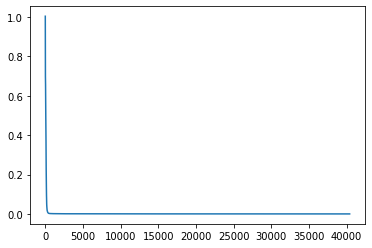

In [212]:
import matplotlib.pyplot as plt
import numpy as np

entropy_value = []
temp = []
for data_one in data:
    value = data_one[3]
    #print(value)
    if value >= 0.01:
        temp.append(data_one)
    entropy_value.append(value)


print(len(temp))
entropy_value = np.array(entropy_value)
x = np.arange(len(entropy_value))    
plt.plot(x, entropy_value) 
plt.show()

In [213]:
for t in temp:
    if not os.path.exists('receipt_data/anno_test/' + t[1]):
        os.makedirs('receipt_data/anno_test/' + t[1], exist_ok=True)
    print(t)
    shutil.copy(t[0], 'receipt_data/anno_test/' + t[1])
    #print(t)

['receipt_data/test_data/MC02000075992839_90150629214102_94.jpg', '其它材料', '其它材料', 1.0043302774429321]
['receipt_data/test_data/MC02000075967956_90150629109995_10.jpg', '其它材料', '门诊病历', 0.9148781299591064]
['receipt_data/test_data/MC02000075564093_90150627309507_8.jpg', '住院记录', '其它材料', 0.851356029510498]
['receipt_data/test_data/MC02000076617106_90150632040323_2.jpg', '费用明细单', '费用明细单', 0.8445324897766113]
['receipt_data/test_data/MC02000076019414_90150629317859_10.jpg', '其它材料', '检验单', 0.8245469331741333]
['receipt_data/test_data/MC02000075977997_90150629137481_4.jpg', '医疗发票', '其它材料', 0.8222886323928833]
['receipt_data/test_data/MC02000075967956_90150629109995_12.jpg', '住院记录', '门诊病历', 0.8008424043655396]
['receipt_data/test_data/MC02000075311115_90150626155195_5.jpg', '其它材料', '其它材料', 0.7916582822799683]
['receipt_data/test_data/MC02000079704765_90150646888966_2.jpg', '其它材料', '费用明细单', 0.7869839072227478]
['receipt_data/test_data/MC02000076123708_90150629795522_1.jpg', '费用明细单', '费用明细单', 0.7

['receipt_data/test_data/MC02000080422137_90150650429114_1.jpg', '其它材料', '其它材料', 0.017512770369648933]
['receipt_data/test_data/MC02000080319722_90150649933125_4.jpg', '其它材料', '住院记录', 0.0174702201038599]
['receipt_data/test_data/MC02000076010042_90150629302782_5.jpg', '费用明细单', '费用明细单', 0.01711733266711235]
['receipt_data/test_data/MC02000075949640_90150629010014_34.jpg', '其它材料', '费用明细单', 0.016506018117070198]
['receipt_data/test_data/MC02000075106204_90150625206295_5.jpg', '住院记录', '其它材料', 0.0161473136395216]
['receipt_data/test_data/MC02000077013703_90150634007146_3.jpg', '其它材料', '其它材料', 0.016075048595666885]
['receipt_data/test_data/MC02000075523372_90150627232292_13.jpg', '其它材料', '费用明细单', 0.015999557450413704]
['receipt_data/test_data/MC02000076607806_90150632009148_11.jpg', '小票', '费用明细单', 0.015751520171761513]
['receipt_data/test_data/MC02000079926691_90150648112367_2.jpg', '门诊病历', '其它材料', 0.01528098527342081]
['receipt_data/test_data/MC02000081145950_90150653875880_6.jpg', '费用明细单',

In [43]:
import os
all_files = []
for root, dirs, files in os.walk('receipt_data/data_v2/'):
    for file in files:
        all_files.append(file)

In [51]:
count, num = 0, 0
for data_one in data:
    print(data_one)
    if data_one[0].split('/')[-1] not in all_files:
        num += 1
    count += 1
    if count == 800:
        break
print(num)

['receipt_data/test_data/MC02000076292371_90150630516893_2.jpg', '费用结算单', '医疗发票', 1.0112675428390503]
['receipt_data/test_data/MC02000076455916_90150631246340_4.jpg', '费用结算单', '费用明细单', 0.8788942098617554]
['receipt_data/test_data/MC02000076106005_90150629714423_4.jpg', '其它材料', '费用明细单', 0.8208880424499512]
['receipt_data/test_data/MC02000077307526_90150635246893_99.jpg', '小票', '费用明细单', 0.755976140499115]
['receipt_data/test_data/MC02000076536773_90150631621087_3.jpg', '门诊病历', '其它材料', 0.7479912042617798]
['receipt_data/test_data/MC02000075405644_90150626577074_4.jpg', '其它材料', '医疗发票', 0.7400579452514648]
['receipt_data/test_data/MC02000075915884_90150628865286_4.jpg', '费用明细单', '费用明细单', 0.739633321762085]
['receipt_data/test_data/MC02000075858482_90150628641313_13.jpg', '费用明细单', '费用明细单', 0.7390146851539612]
['receipt_data/test_data/MC02000076642716_90150632357975_6.jpg', '医疗发票', '医疗发票', 0.6955084204673767]
['receipt_data/test_data/MC02000077307530_90150635246809_8.jpg', '费用明细单', '医疗发票', 0.

In [127]:
zhuyuan_files = open('origin_data/zhuyuan_record.txt').read().split('\n')
for zhuyuan_file in zhuyuan_files:
    shutil.copy('origin_data/orig_data/' + zhuyuan_file, 'origin_data/zhuyuan_record/')

In [1]:
import cv2
import torchvision.transforms as T
from PIL import Image

image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])            

img_path = 'receipt_data/data_v2/1/MC02000058656292_90150549248495_17.jpg'
img_data = cv2.imread(img_path)
print(img_data.shape)
image_data = Image.open(img_path)
print(image_data.size)
image = image_transform(img_data)

(1754, 1240, 3)
(1240, 1754)


TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>